# Распознавание текстовых полей документа - СНИЛС

##### Optical Character Recognition of "СНИЛС"

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image

import cv2
import tesserocr
import pandas as pd
import json

#from utils import label_map_util
from utils import visualization_utils as vis_util

PATH_TO_CKPT = 'snils_graph/frozen_inference_graph.pb' # Путь к обученной модели нейросети

PATH_TO_LABELS = 'training_snils/labelmap.pbtxt'  # Путь к label-файлу

PATH_TO_TEST_IMAGE = 'snils_data/image1.jpg' # Путь к распознаваемому изображению

NUM_CLASSES = 1

classs = dict(text='1')

In [2]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Распознавание интересующих полей на документе

In [3]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        sess.run(tf.global_variables_initializer())
        image = Image.open(PATH_TO_TEST_IMAGE)
        (im_width, im_height) = image.size 
        image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
        to_pixel = np.array([im_height, im_width, im_height, im_width])
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})  
        image2 = cv2.imread(PATH_TO_TEST_IMAGE)
        vis_util.visualize_boxes_and_labels_on_image_array(
            image2,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            classs,
            use_normalized_coordinates=True,
            line_thickness=3,
            min_score_thresh=0.80)

### Изображение распознаваемого документа

In [ ]:
img = Image.fromarray(image2, 'RGB')

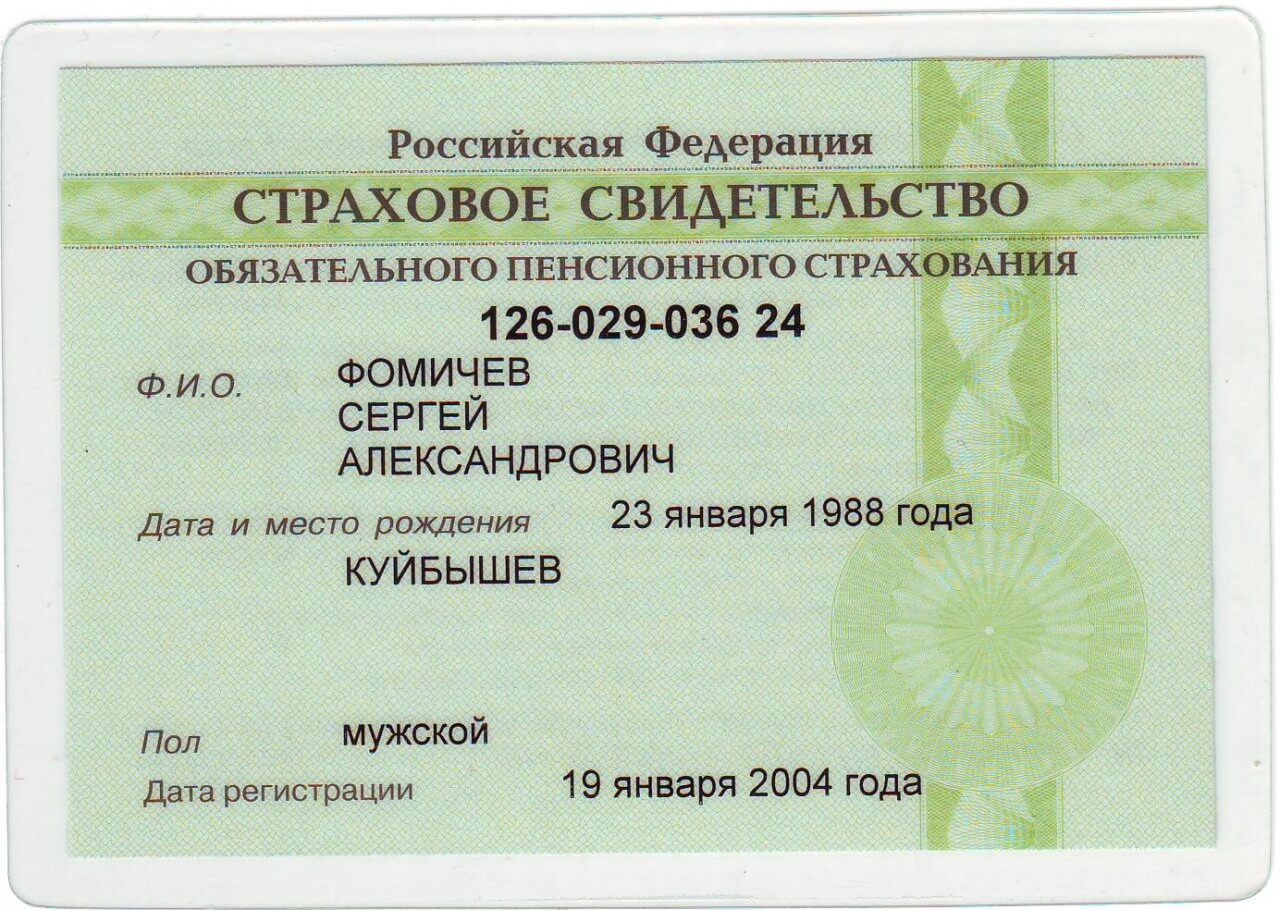

In [4]:
img

### Переведем координаты распознанных блоков в табличный вид

In [5]:
j = int(num_detections[0]) # Число выявленных блоков
table = pd.DataFrame()
tab_1 = []
tab_2 = []
tab_3 = []
tab_4 = []
for i in range(0,j):
    tab_1 = tab_1 + [boxes.T[1][i][0]]
    tab_2 = tab_2 + [boxes.T[3][i][0]]
    tab_3 = tab_3 + [boxes.T[0][i][0]]
    tab_4 = tab_4 + [boxes.T[2][i][0]]

table['y min'] = tab_3
table['x min'] = tab_1
table['y max'] = tab_4
table['x max'] = tab_2

table

,y min,x min,y max,x max
0,0.833013,0.437021,0.884909,0.728361
1,0.537827,0.471261,0.590085,0.771321
2,0.484029,0.247427,0.525792,0.533275
3,0.599975,0.255848,0.652620,0.443991
4,0.317605,0.364988,0.383719,0.640480
5,0.433077,0.252780,0.475826,0.389095
6,0.781632,0.255482,0.830129,0.391253
7,0.386812,0.258970,0.432136,0.415878


### Отсортируем таблицу по максимальному значению y

In [6]:
table = table.sort_values('y max')

table

,y min,x min,y max,x max
4,0.317605,0.364988,0.383719,0.640480
7,0.386812,0.258970,0.432136,0.415878
5,0.433077,0.252780,0.475826,0.389095
2,0.484029,0.247427,0.525792,0.533275
1,0.537827,0.471261,0.590085,0.771321
3,0.599975,0.255848,0.652620,0.443991
6,0.781632,0.255482,0.830129,0.391253
0,0.833013,0.437021,0.884909,0.728361


### Переведем относительные координаты в координатные пиксели 

In [7]:
table = table * to_pixel

table

,y min,x min,y max,x max
4,289.020187,467.185211,349.183935,819.814911
7,351.999165,331.481895,393.243759,532.323494
5,394.100240,323.558121,433.001493,498.041725
2,440.466331,316.707172,478.470289,682.592621
1,489.422963,603.213882,536.977377,987.290802
3,545.976970,327.485809,593.884162,568.308792
6,711.285180,327.016869,755.417144,500.804367
0,758.041883,559.387131,805.267275,932.302246


### Произведем нарезку изображения на интересующие текстовые блоки

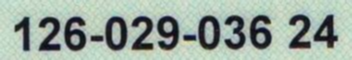

In [8]:
images_new = []
for i in range(0,j):
    img = image.crop( (int(table['x min'].iloc[i]),int(table['y min'].iloc[i]),int(table['x max'].iloc[i]),int(table['y max'].iloc[i]) )) #дата
    img.save('cropp_'+str(i)+'.jpg')
    img = cv2.imread('cropp_'+str(i)+'.jpg')
    img = Image.fromarray(cv2.GaussianBlur(img,(3,3),0))
    images_new = images_new + [img]
    
images_new[0] 

### Применяем модуль tesserocr для OCR каждого изображения текстового блока в отдельности

In [41]:
text = []
for img in images_new:
    tex = tesserocr.image_to_text(img, lang='rus')
    tex = tex.replace(',', '.').replace("\n", '').replace("’", '').replace("'", '').replace('"', '').replace("?", '').replace("‘", '')
    text.append(tex)
for i in range(len(text),8):
    text.append('')
text

['126-029-036 24',
 'ФОМИЧЕВ',
 'СЕРГЕЙ',
 'АЛЕКСАНДРОВИЧ',
 '23 января 1988 года',
 'КУЙБЫШЕВ',
 'мужской',
 '19 января 2004 года']

### Структурируем информацию в словаре

In [31]:
data = {
    "number": text[0],
    "surname": text[1],
    "name": text[2],
    "patronymic": text[3],
    "birthday": text[4],
    "birthplace": text[5],
    "gender": text[6],   
    "registration": text[7]   
}

data

{'birthday': '23 января 1988 года',
 'birthplace': 'КУЙБЫШЕВ',
 'gender': 'мужской',
 'name': 'СЕРГЕЙ',
 'number': '126-029-036 24',
 'patronymic': 'АЛЕКСАНДРОВИЧ',
 'registration': '19 января 2004 года',
 'surname': 'ФОМИЧЕВ'}

### Производим запись в JSON файл

In [11]:
with open("data_file.json", "w") as write_file:
    json.dump(data, write_file)

    #                                                   successfully!